# Reproduce method from Varghese 2011

I'm going to try and reproduce streams. I'm not going to use orbitsf90. I think it will be too difficult. Better with Galpy, but I anticipate problems... 

- Not having the same potential model available that the streams were computed in
    - unless I can figure out how to include the power law scalaing...
- Galpy units are still a but confusing
- Not sure how to do gradient descent to get better orbit determination... 
- how to measure the goodness of fit

In [29]:
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014 as MW14
from galpy.util import conversion

import numpy as np 
import matplotlib.pyplot as plt 
import h5py 
import trace_orbit as TO 
import json
import sys 
sys.path.append("/home/sferrone/GC-tidal-loss/simulations/analytic-GC-tidal-loss/code")
import inputMW
import orbitCoords as OC
import astropy.coordinates as coord
import astropy.units as u


### view the stream in xy,yz

In [30]:
k=0
GCnames,version,model=np.loadtxt("clean_stream.txt",delimiter=',',dtype=str,unpack=True)
f=open("config.json")
C = json.load(f)
dt=0.3
backwardpath,forwardpath=TO.orbitpath(C)
streampath=TO.get_streampath(version=version[k],model=model[k])
stream=h5py.File(streampath+GCnames[k]+".h5")
t,W=TO.load_orbit(backwardpath,forwardpath,GCnames[k],C)
plt.style.use('dark_background')
dt=0.05
COM=OC.getCOM(GCnames[k])
past,future,x,y,z,vx,vy,vz=TO.absTimeFilter(dt,t,W)

EDR3 PII


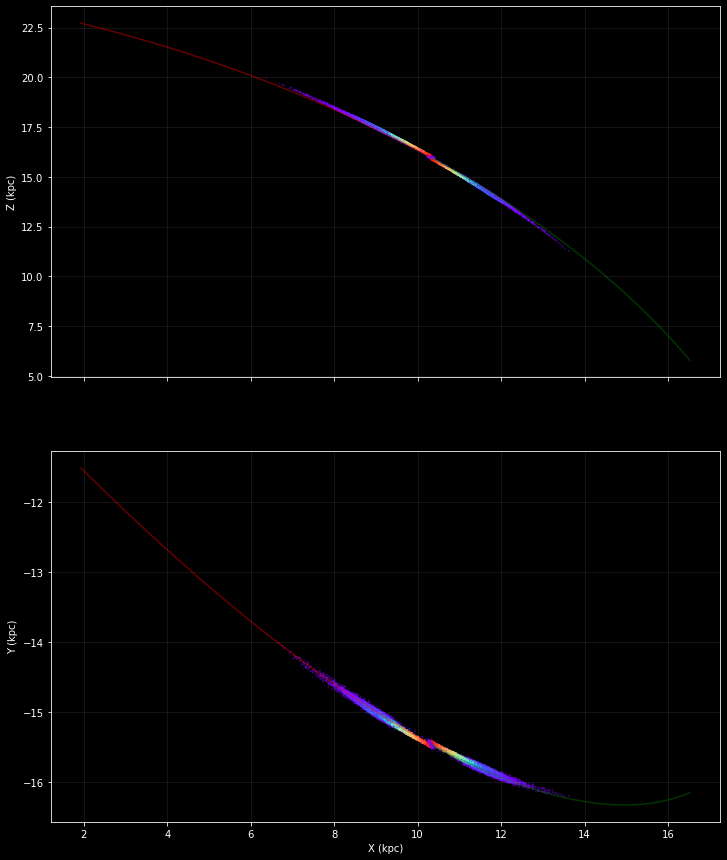

In [31]:
fig,ax=plt.subplots(2,1,sharex=True,figsize=(12,15))
coat=stream['energy']['Tescape'][:]
coat[coat<0]=0
ax[0].plot(x[past],z[past],alpha=0.4,c='r')
ax[0].plot(x[future],z[future],alpha=0.4,c='g')
ax[0].scatter(stream['galactocentric']['X'][:],stream['galactocentric']['Z'][:],c=coat,alpha=0.7,s=0.1,cmap=plt.cm.get_cmap("rainbow"))
ax[1].scatter(stream['galactocentric']['X'][:],stream['galactocentric']['Y'][:],c=coat,alpha=0.7,s=0.1,cmap=plt.cm.get_cmap("rainbow"))
ax[1].plot(x[past],y[past],alpha=0.4,c='r')
ax[1].plot(x[future],y[future],alpha=0.4,c='g')
ax[1].set_xlabel("X (kpc)")
ax[0].set_ylabel("Z (kpc)")
ax[1].set_ylabel("Y (kpc)")
for xx in ax:
    xx.grid("On",alpha=0.1)

let us see it on the sky 

In [32]:
c=coord.SkyCoord(x=x*u.kpc,y=y*u.kpc,z=z*u.kpc,frame=inputMW.ref_frame())
cORB=c.transform_to(coord.Galactic())
c=coord.SkyCoord(x=stream['galactocentric']['X'][:]*u.kpc,y=stream['galactocentric']['Y'][:]*u.kpc,z=stream['galactocentric']['Z'][:]*u.kpc,frame=inputMW.ref_frame())
cSTM=c.transform_to(coord.Galactic())

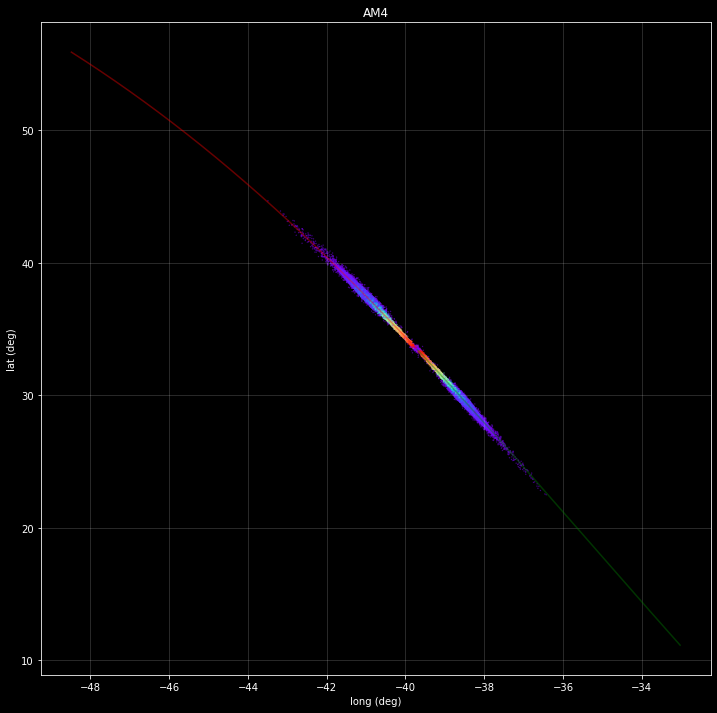

In [33]:
fig,ax=plt.subplots(1,1,figsize=(12,12))
ax.plot(cORB.l.wrap_at(180*u.degree)[past],cORB.b[past],c='r',alpha=0.4)
ax.plot(cORB.l.wrap_at(180*u.degree)[future],cORB.b[future],c='g',alpha=0.4)
ax.scatter(cSTM.l.wrap_at(180*u.degree),cSTM.b,c=coat,alpha=0.7,s=0.1,cmap=plt.cm.get_cmap("rainbow"))
ax.set_ylabel("lat (deg)"),ax.set_xlabel("long (deg)"),ax.set_title(GCnames[k])        
# ax.set_aspect("equal")
ax.grid("On",alpha=0.2)

# Replicate the GC orbit with Galpy

In [34]:
# MAKE THE VELOCITY AND CYLINDRICAL RADIUS VECTORS
vel=np.array([COM.v_x.value, COM.v_y.value, COM.v_z.value])
RR = np.array([COM.x.value, COM.y.value,0])
R=np.sqrt (COM.x**2 + COM.y**2)
magR = np.linalg.norm(RR)*u.kpc
RUnit = RR/np.linalg.norm(RR) # cannot use "Quantity" 
zUnit=[0,0,1]
tanUnit=np.cross(zUnit,RUnit)
# project velocity onto these axis and re-add units so that they are "Qauntity" objs
vT=np.dot(vel,tanUnit)*u.km/u.s
vR=np.dot(vel,RUnit)*u.km/u.s
vZ=np.dot(vel,[0,0,1])*u.km/u.s

phi = np.arctan2(COM.y,COM.x)
phi=phi.value*(180/np.pi)*u.degree

print("Verify that the speed is the same before and after conversion")
print(np.linalg.norm(vel),np.linalg.norm(np.array([vT.value,vR.value,vZ.value])))


Verify that the speed is the same before and after conversion
236.82399975543242 236.82399975543242


In [35]:
orbB,orbF=Orbit([R,-vR,-vT,COM.z,-vZ,phi]),Orbit([R,vR,vT,COM.z,vZ,phi])
t0,tf,N=0,0.15*(2*np.pi),100
ts=np.linspace(t0,tf,N)
orbB.integrate(ts,MW14),orbF.integrate(ts,MW14);

In [36]:
conv=conversion.get_physical(orbB)
myxB,myyB=orbB.getOrbit()[:,0]*np.cos(orbB.getOrbit()[:,5]),orbB.getOrbit()[:,0]*np.sin(orbB.getOrbit()[:,5])
myxF,myyF=orbF.getOrbit()[:,0]*np.cos(orbF.getOrbit()[:,5]),orbF.getOrbit()[:,0]*np.sin(orbF.getOrbit()[:,5])
myxB,myyB=conv['ro']*myxB,conv['ro']*myyB
myxF,myyF=conv['ro']*myxF,conv['ro']*myyF
CX,CY=orbF.R()*np.cos(orbF.phi()),orbF.R()*np.sin(orbF.phi())

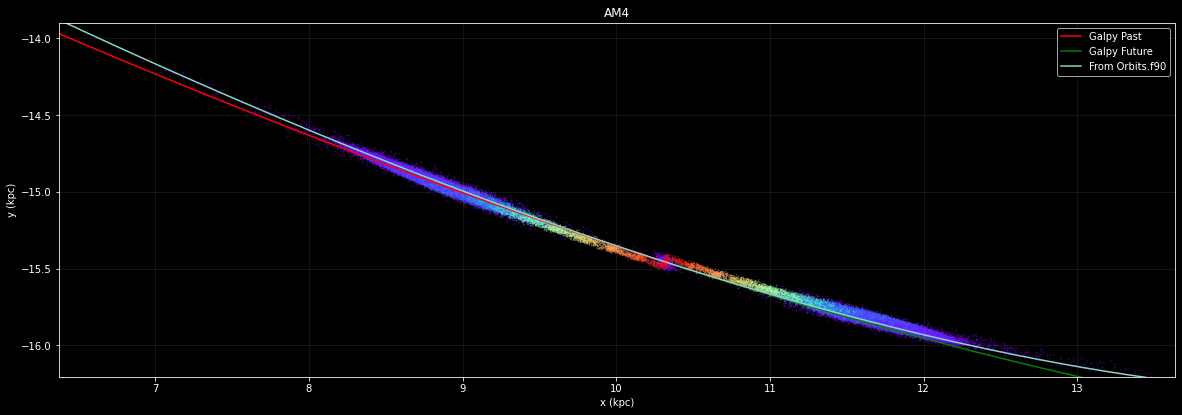

In [37]:
fig,ax=plt.subplots(1,1,figsize=(20,20))
ax.plot(myxB,myyB,'r',label="Galpy Past"),ax.plot(myxF,myyF,'g',label="Galpy Future"),ax.plot(CX,CY, 'ro')
ax.scatter(stream['galactocentric']['X'][:],stream['galactocentric']['Y'][:],\
            c=coat,alpha=0.7,s=0.1,cmap=plt.cm.get_cmap("rainbow"))
ax.plot(x,y,label="From Orbits.f90")
ax.set_xlabel("x (kpc)"),ax.set_ylabel("y (kpc)"),ax.grid("on",alpha=0.1)
ax.legend()
ax.set_ylim(stream['galactocentric']['Y'][:].min(),stream['galactocentric']['Y'][:].max())
ax.set_xlim(stream['galactocentric']['X'][:].min(),stream['galactocentric']['X'][:].max())
ax.set_aspect("equal")
ax.set_title(GCnames[k]);

# THE JACOBI RADIUS 

$ 4 \pi G \rho = \nabla^2 \Phi $

INTEGRATE OVER THE VOLUME

$ \int 4 \pi G \rho dV  = \int \nabla^2 \Phi dV$

$ 4 \pi G M = \int \nabla \cdot \nabla \Phi dV  $

DIVERGENCE THEOREM 

$ 4 \pi G M = \oiint  \vec{\nabla \Phi} \cdot \vec{dS}  $

ASSUME SPHERICAL SYMMETRY - which ensures $\vec{\nabla \Phi}$ will be only along $\^{r} $

$ 4 \pi G M =  |\vec{\nabla \Phi}| 4 \pi r^2  $

$  G M  r^{-2}=  |\vec{\nabla \Phi}|    $

SO IF WE HAVE THE POTENTIAL, AND ASSUME SPHERICAL SYMMETRY, THEN THE INTERIOR MASS IS:

$   M(r)  =  |\vec{\nabla \Phi}|r^{2} G^{-1}    $


GIVEN THIS, AND THE JACOBII RADIUS FROM Varghese et al 2011:

$ r_{cutt-off} = 2.88 \times \left(\frac{m_{sat}}{3\~{M}(r)}  \right)^{1/3} r$

NOTICE ! that they give the little squiggle (informally known as the tilde) to the host mass within r, $\~{M}(r)$

### Calculate the interior mass and jacobii radius?

From out simulations, I have |$\nabla \Phi$|

In [38]:
# get the mass of a GC
import inputGC
params=inputGC.Plummer(GCnames[k])
print(params)

[756.0, 0.011496314048113196]


In [39]:
def calcJacobii(laX,laY,laZ,satmass):
    """ CALCULATE THE THEORHETICAL JACOBI RADIUS
    For a satelite orbiting the galactic center
    assuming, fasly, in a spherically symmetric potential
    """
    G=1
    TOSOLAR=2.32*10**7
    ax,ay,az,_=inputMW.potMW(laX,laY,laZ,0,"PII")
    nabPhi=np.sqrt(ax**2 + ay**2 + az**2)
    r = np.sqrt(laX**2 + laY**2 + laZ**2)
    MASS = nabPhi*(r**2)*G*TOSOLAR
    jacobii=2.88 * ((satmass/MASS)**(1/3))*r 
    return jacobii


In [40]:
def cyl_to_cart(cylin):
    """
    THERE's NO NEED FOR THIS!
    ASTROPY ALREADY DOES THIS!
    cylin=[R, vR, vT, z, vZ, phi]
    """
    R, vR, vT, z, vZ, phi=cylin[0],cylin[1],cylin[2],cylin[3],cylin[4],cylin[5]
    x,y=R*np.cos(phi),R*np.sin(phi)
    Rvec=np.array([x,y,0])
    Rmax=np.linalg.norm(Rvec)
    Runit=Rvec/Rmax 
    tanUnit=np.cross([0,0,1],Runit)
    VZ = np.array([0,0,vZ])
    VR = vR*Runit
    VT = vT*tanUnit
    vel=VZ+VR+VT
    return np.array([x,y,z,vel[0],vel[1],vel[2]])


In [41]:
import time 

[R, vR, vT, z, vZ, phi]

### Trying again to compute the orbits because the previous attempt did not give me the correct coordiantes

- maybe the first attemps was an issue of coordiante transformation? 
- also not sure if I can use the astropy coordiante transforms for velocity vectors
- it looks like my issue had to do with time of integration and such...
- i also needed to flip the backward orbit vector and concatenate them. 

### Generate a series of initial conditions

In [42]:
def escapeConditions(R, vR, vT, z, vZ, phi,satmass,conv):
    """
    insert the coordinates of progenitor in natural units
    
    return the kinematics at the escape points in galpy format and in "natural" units
    
    assumes co-motion of the progenitor ie. forward moving orbit in time
    
    the interior and exterior escape particles have the same velocity as the GC
    
    """
    laX,laY=conv['ro']*R*np.cos(phi),conv['ro']*R*np.sin(phi)
    lat=np.arcsin(z/np.sqrt(R**2 + z**2))
    jacobii=calcJacobii(laX,laY,conv['ro']*z,satmass)/conv['ro']
    rint = np.sqrt(R**2 + z**2) - jacobii
    rext = np.sqrt(R**2 + z**2) + jacobii
    Rint,zint=rint*np.cos(lat),rint*np.sin(lat)
    Rext,zext=rext*np.cos(lat),rext*np.sin(lat)
    interior = [Rint,vR,vT,zint,vZ,phi]
    exterior = [Rext,vR,vT,zext,vZ,phi]
    return interior,exterior

In [43]:
satmass=params[0]
borbit=orbB.getOrbit()
forbit=orbF.getOrbit()
ok=np.flip(borbit,axis=0)
ok[:,[1,2,4]]*=-1
fullorbit=np.concatenate([ok[:-1,:],forbit])
initExt0=np.zeros((N-2,6))
initInt0=np.zeros((N-2,6))
finalExt=np.zeros((N-2,6))
finalInt=np.zeros((N-2,6))
intorbs=[]

for i in range(N-2):
    R, vR, vT, z, vZ, phi = fullorbit[i,:]
    interior,exterior=escapeConditions(R, vR, vT, z, vZ, phi,satmass,conv)
    intOrb=Orbit(interior)
    extOrb=Orbit(exterior)
    inttime=np.array([0,tf-ts[i]])
    inttime=np.linspace(0,tf-ts[i],N-i)
    intOrb.integrate(inttime,MW14)
    extOrb.integrate(inttime,MW14)
    initInt0[i,:] = interior
    initExt0[i,:] = exterior
    finalInt[i,:]=intOrb.getOrbit()[-1,:]
    finalExt[i,:]=extOrb.getOrbit()[-1,:]

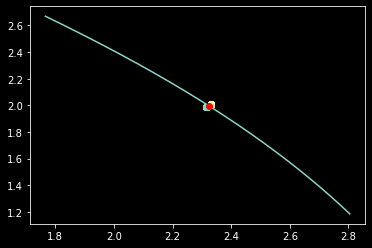

In [44]:
plt.plot(fullorbit[:,0],fullorbit[:,3])
plt.plot(fullorbit[N-1,0],fullorbit[N-1,3],'or')
plt.scatter(finalInt[:,0],finalInt[:,3])
plt.scatter(finalExt[:,0],finalExt[:,3])


The particle stream works!! Now, how long back in time should I integrate for?

# Integration time?

this should be consistent with Dehnen et al 2004

### $\tau = \frac{\delta x'}{\delta v}$

where x' is the length of the stream and $\delta v$ is the "drift velocity"

What should the dift velocity be? It should be from the difference in energy between the particle and the GC as the particle escapes...

#### $(1/2) \delta v^2 \approx \Delta E$

#### $\delta v = \sqrt{ 2\Delta E} $

and in this case, since we give the particle the same velocity as the GC, the only difference is going to be the potential energy.


#### $\Delta E \approx |\Phi(r+r_j) - \Phi(r)|$ OR $\Delta E \approx |\Phi(r-r_j) - \Phi(r)|$

where $r$ is the position of the GC and $r_j$ is the jacobi radius at that position

so the integration time should be approximately

## $\tau_{drift} \approx \frac{x'}{\sqrt{2|\Phi(r+r_j) - \Phi(r)|}} $


In [90]:
from astropy.coordinates import cartesian_to_spherical,spherical_to_cartesian
xprime = 2.5 * u.kpc # for now just pick this, calculate it after
rjac=calcJacobii(COM.x.value,COM.y.value,COM.z.value,satmass)
r,lat,lon=cartesian_to_spherical(COM.x.value,COM.y.value,COM.z.value)
xp,yp,zp=spherical_to_cartesian(r-rjac,lat,lon)
# deproject
_,_,_,phi0 = inputMW.potMW(COM.x.value,COM.y.value,COM.y.value,0,"PII")
_,_,_,phiInt=inputMW.potMW(xp,yp,zp,0,"PII")
dE=np.abs(phi0-phiInt)
vDLess = np.sqrt(2*dE)/conv['vo']
xprimeDLess=xprime.value/conv['ro']
tau=xprimeDLess/vDLess.value
print(tau, "in 'natural units'")
print(tau*(conv['ro']/conv['vo']), "100 Myrs")
print("or at least it should be? I should verify with these integration units again")


20.89799273010946 in 'natural units'
0.7599270083676167 100 Myrs
or at least it should be? I should verify with these integration units again


In [91]:
def cart_to_cylin(x,y,z,vx,vy,vz):
    """  
    Purpose! 
    the positions must be in KPC
    the velocities must be in km/s ! 
    returns R, vR, vT, z, vZ, phi
    """
    vel=np.array([vx, vy, vz])
    RR = np.array([x, y,0])
    magR = np.linalg.norm(RR)
    R=magR*u.kpc
    RUnit = RR/magR # cannot use "Quantity" 
    zUnit=[0,0,1]
    tanUnit=np.cross(zUnit,RUnit)
    # project velocity onto these axis and re-add units so that they are "Qauntity" objs
    vT=np.dot(vel,tanUnit)*u.km/u.s
    vR=np.dot(vel,RUnit)*u.km/u.s
    vZ=np.dot(vel,[0,0,1])*u.km/u.s
    phi = np.arctan2(y,x)*(180/np.pi)*u.degree
    z*=u.kpc
    return R,vR,vT,z,vZ,phi

### compute the orbit backwards in time with this information...

In [92]:
R,vR,vT,z,vZ,phi=cart_to_cylin(COM.x.value,COM.y.value,COM.z.value,\
    COM.v_x.value,COM.v_y.value,COM.v_z.value)
orbB,orbF=Orbit([R,-vR,-vT,z,-vZ,phi]),Orbit([R,vR,vT,z,vZ,phi])
Np=300
ts=np.linspace(0,tau,Np)
orbB.integrate(ts,MW14),orbF.integrate(ts,MW14);

Text(0, 0.5, 'Z (nat units)')

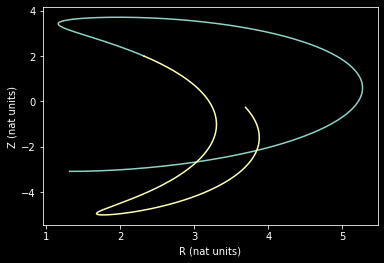

In [103]:
plt.plot(orbB.getOrbit()[:,0],orbB.getOrbit()[:,3])
plt.plot(orbF.getOrbit()[:,0],orbF.getOrbit()[:,3])
plt.xlabel("R (nat units)")
plt.ylabel("Z (nat units)")

this is weird and very interesting to note. So perhaps I'm going to discovery that my drift rate calculation was wrong, or that the drift rate of particle spray is much faster than the test-particle method

In [94]:
def particleSpray(ts,fullorbit,satmass,conv):
    """ 
    All in natural units. 
    find the final positions of the particles that escape from the time stamps given by ts
    
    ts must be the N//2 where N is the length of full orbit
    """
    N = ts.shape[0]
    leadingF=np.zeros((N-2,6))
    trailingF=np.zeros((N-2,6))
    tf=ts[-1]
    for i in range(N-2):
        R, vR, vT, z, vZ, phi = fullorbit[i,:]
        interior,exterior=escapeConditions(R, vR, vT, z, vZ, phi,satmass,conv)
        intOrb=Orbit(interior)
        extOrb=Orbit(exterior)
        inttime=np.linspace(0,tf-ts[i],N-i)
        intOrb.integrate(inttime,MW14)
        extOrb.integrate(inttime,MW14)
        leadingF[i,:]=intOrb.getOrbit()[-1,:]
        trailingF[i,:]=extOrb.getOrbit()[-1,:]
    return leadingF,trailingF

In [95]:
R,vR,vT,z,vZ,phi=cart_to_cylin(COM.x.value,COM.y.value,COM.z.value,\
    COM.v_x.value,COM.v_y.value,COM.v_z.value)
orbB,orbF=Orbit([R,-vR,-vT,z,-vZ,phi]),Orbit([R,vR,vT,z,vZ,phi])
Np=300
ts=np.linspace(0,tau,Np)
orbB.integrate(ts,MW14),orbF.integrate(ts,MW14);
satmass=params[0]
borbit,forbit=orbB.getOrbit(),orbF.getOrbit()
ok=np.flip(borbit,axis=0)
ok[:,[1,2,4]]*=-1
fullorbit=np.concatenate([ok[:-1,:],forbit])

In [97]:
leadingF,trailingF=particleSpray(ts,fullorbit,satmass,conv)

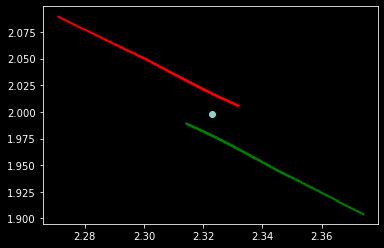

In [98]:
fig,ax=plt.subplots(1,1)
middex=fullorbit.shape[0]//2
# ax.plot(fullorbit[:,0],fullorbit[:,4])
ax.scatter(fullorbit[middex,0],fullorbit[middex,3])
ax.scatter(leadingF[:,0],leadingF[:,3],c='g',s=1)
ax.scatter(trailingF[:,0],trailingF[:,3],c='r',s=1)

This $\tau$ is for sure way too long

In [99]:
tcolor=(ts[-1]-ts[:-2])*(conv['ro']/conv['vo'])
tcolor.min(),tcolor.max()

(0.005083123801790117, 0.7599270083676167)

In [100]:
from astropy.coordinates import CylindricalRepresentation
cylin=CylindricalRepresentation(leadingF[:,0],z=leadingF[:,3],phi=leadingF[:,5]*u.rad)
xpL,ypL,zpL=cylin.to_cartesian().x.value,cylin.to_cartesian().y.value,cylin.to_cartesian().z.value
cylin=CylindricalRepresentation(trailingF[:,0],z=trailingF[:,3],phi=trailingF[:,5]*u.rad)
xpF,ypF,zpF=cylin.to_cartesian().x.value,cylin.to_cartesian().y.value,cylin.to_cartesian().z.value

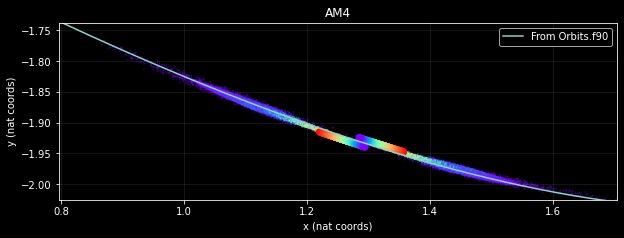

In [101]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
strmX=stream['galactocentric']['X'][:]/conv['ro']
strmY=stream['galactocentric']['Y'][:]/conv['ro']

ax.scatter(strmX,strmY,\
            c=coat,alpha=0.7,s=0.1,cmap=plt.cm.get_cmap("rainbow"))
ax.plot(x/conv['ro'],y/conv['ro'],label="From Orbits.f90")
ax.set_xlabel("x (nat coords)"),ax.set_ylabel("y (nat coords)"),ax.grid("on",alpha=0.1)
ax.legend()

ax.scatter(xpL,ypL,c=tcolor,cmap=plt.cm.get_cmap("rainbow"))
ax.scatter(xpF,ypF,c=tcolor,cmap=plt.cm.get_cmap("rainbow"))
ax.set_ylim(strmY.min(),strmY.max())
ax.set_xlim(strmX.min(),strmX.max())

ax.set_aspect("equal")
ax.set_title(GCnames[k]);


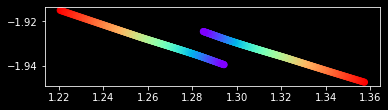

In [102]:
fig,ax=plt.subplots(1,1)
ax.scatter(xpL,ypL,c=tcolor,cmap=plt.cm.get_cmap("rainbow"))
ax.scatter(xpF,ypF,c=tcolor,cmap=plt.cm.get_cmap("rainbow"))
ax.set_aspect("equal")

There's a huge discrepency with the escape times and distances... this one here is much faster. This calculated drift rate is too fast...

So lemme try another way?

# $\delta v = \left|\frac{\Phi(r)-\Phi(r+r_j)}{v_{gc}}\right|$



In [135]:
xprime = 2.5 * u.kpc # for now just pick this, calculate it after
rjac=calcJacobii(COM.x.value,COM.y.value,COM.z.value,satmass)
r,lat,lon=cartesian_to_spherical(COM.x.value,COM.y.value,COM.z.value)
xp,yp,zp=spherical_to_cartesian(r-rjac,lat,lon)

In [157]:
_,_,_,phi0 = inputMW.potMW(COM.x.value,COM.y.value,COM.y.value,0,"PII")
_,_,_,phiInt=inputMW.potMW(xp,yp,zp,0,"PII")
Vgc=np.linalg.norm([COM.v_x.value,COM.v_y.value,COM.v_z.value])
vdrift=np.abs(phiInt-phi0)/Vgc
tau=xprime.value/vdrift.value
tauD=tau*(conv['vo']/conv['ro'])

In [160]:
R,vR,vT,z,vZ,phi=cart_to_cylin(COM.x.value,COM.y.value,COM.z.value,\
    COM.v_x.value,COM.v_y.value,COM.v_z.value)
orbB,orbF=Orbit([R,-vR,-vT,z,-vZ,phi]),Orbit([R,vR,vT,z,vZ,phi])
Np=300
ts=np.linspace(0,tauD,Np)
orbB.integrate(ts,MW14),orbF.integrate(ts,MW14);
satmass=params[0]
borbit,forbit=orbB.getOrbit(),orbF.getOrbit()
ok=np.flip(borbit,axis=0)
ok[:,[1,2,4]]*=-1
fullorbit=np.concatenate([ok[:-1,:],forbit])

Text(0, 0.5, 'Z (nat units)')

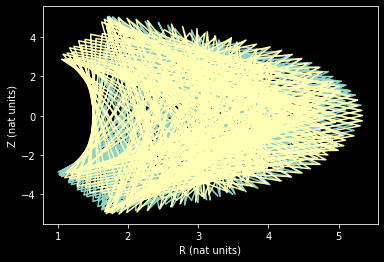

In [161]:
plt.plot(orbB.getOrbit()[:,0],orbB.getOrbit()[:,3])
plt.plot(orbF.getOrbit()[:,0],orbF.getOrbit()[:,3])
plt.xlabel("R (nat units)")
plt.ylabel("Z (nat units)")

this is going to be waaaay to much... unless the under sampling is getting to me?

In [162]:
leadingF,trailingF=particleSpray(ts,fullorbit,satmass,conv)

In [163]:
tcolor=(ts[-1]-ts[:-2])*(conv['ro']/conv['vo'])
print(tcolor.min(),tcolor.max())
cylin=CylindricalRepresentation(leadingF[:,0],z=leadingF[:,3],phi=leadingF[:,5]*u.rad)
xpL,ypL,zpL=cylin.to_cartesian().x.value,cylin.to_cartesian().y.value,cylin.to_cartesian().z.value
cylin=CylindricalRepresentation(trailingF[:,0],z=trailingF[:,3],phi=trailingF[:,5]*u.rad)
xpF,ypF,zpF=cylin.to_cartesian().x.value,cylin.to_cartesian().y.value,cylin.to_cartesian().z.value

0.7318435774800408 109.41061483326592


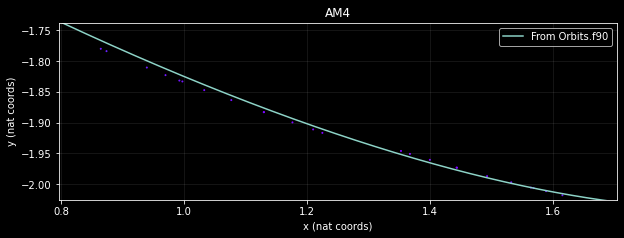

In [166]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
strmX=stream['galactocentric']['X'][:]/conv['ro']
strmY=stream['galactocentric']['Y'][:]/conv['ro']

# ax.scatter(strmX,strmY,\
            # c=coat,alpha=0.7,s=0.1,cmap=plt.cm.get_cmap("rainbow"))
ax.plot(x/conv['ro'],y/conv['ro'],label="From Orbits.f90")
ax.set_xlabel("x (nat coords)"),ax.set_ylabel("y (nat coords)"),ax.grid("on",alpha=0.1)
ax.legend()

ax.scatter(xpL,ypL,c=tcolor,cmap=plt.cm.get_cmap("rainbow"),s=1)
ax.scatter(xpF,ypF,c=tcolor,cmap=plt.cm.get_cmap("rainbow"),s=1)
ax.set_ylim(strmY.min(),strmY.max())
ax.set_xlim(strmX.min(),strmX.max())

ax.set_aspect("equal")
ax.set_title(GCnames[k]);


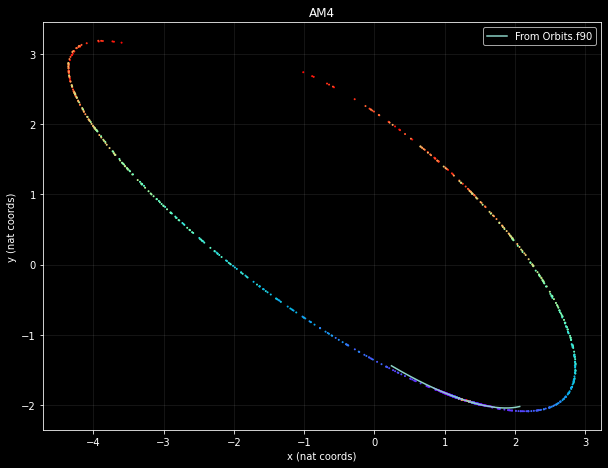

In [167]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
strmX=stream['galactocentric']['X'][:]/conv['ro']
strmY=stream['galactocentric']['Y'][:]/conv['ro']

ax.scatter(strmX,strmY,\
            c=coat,alpha=0.7,s=0.1,cmap=plt.cm.get_cmap("rainbow"))
ax.plot(x/conv['ro'],y/conv['ro'],label="From Orbits.f90")
ax.set_xlabel("x (nat coords)"),ax.set_ylabel("y (nat coords)"),ax.grid("on",alpha=0.1)
ax.legend()

ax.scatter(xpL,ypL,c=tcolor,cmap=plt.cm.get_cmap("rainbow"),s=1)
ax.scatter(xpF,ypF,c=tcolor,cmap=plt.cm.get_cmap("rainbow"),s=1)
# ax.set_ylim(strmY.min(),strmY.max())
# ax.set_xlim(strmX.min(),strmX.max())

ax.set_aspect("equal")
ax.set_title(GCnames[k]);


this is waaaaay too much....

### Try guess and check ?

In [170]:
tau = 5
tauD = tau*(conv['vo']/conv['ro'])
R,vR,vT,z,vZ,phi=cart_to_cylin(COM.x.value,COM.y.value,COM.z.value,\
    COM.v_x.value,COM.v_y.value,COM.v_z.value)
orbB,orbF=Orbit([R,-vR,-vT,z,-vZ,phi]),Orbit([R,vR,vT,z,vZ,phi])
Np=300
ts=np.linspace(0,tauD,Np)
orbB.integrate(ts,MW14),orbF.integrate(ts,MW14);
satmass=params[0]
borbit,forbit=orbB.getOrbit(),orbF.getOrbit()
ok=np.flip(borbit,axis=0)
ok[:,[1,2,4]]*=-1
fullorbit=np.concatenate([ok[:-1,:],forbit])

Text(0, 0.5, 'Z (nat units)')

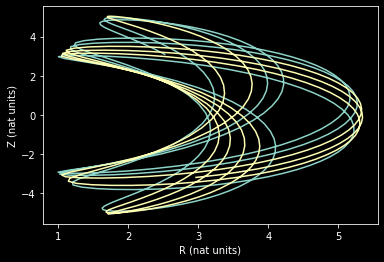

In [171]:
plt.plot(orbB.getOrbit()[:,0],orbB.getOrbit()[:,3])
plt.plot(orbF.getOrbit()[:,0],orbF.getOrbit()[:,3])
plt.xlabel("R (nat units)")
plt.ylabel("Z (nat units)")

With a reasonable looking number of orbits...

In [172]:
leadingF,trailingF=particleSpray(ts,fullorbit,satmass,conv)

In [173]:
tcolor=(ts[-1]-ts[:-2])*(conv['ro']/conv['vo'])
print(tcolor.min(),tcolor.max())
cylin=CylindricalRepresentation(leadingF[:,0],z=leadingF[:,3],phi=leadingF[:,5]*u.rad)
xpL,ypL,zpL=cylin.to_cartesian().x.value,cylin.to_cartesian().y.value,cylin.to_cartesian().z.value
cylin=CylindricalRepresentation(trailingF[:,0],z=trailingF[:,3],phi=trailingF[:,5]*u.rad)
xpF,ypF,zpF=cylin.to_cartesian().x.value,cylin.to_cartesian().y.value,cylin.to_cartesian().z.value

0.033444816053510996 5.0


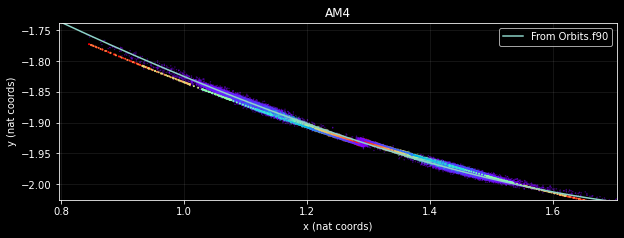

In [174]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
strmX=stream['galactocentric']['X'][:]/conv['ro']
strmY=stream['galactocentric']['Y'][:]/conv['ro']

ax.scatter(strmX,strmY,\
            c=coat,alpha=0.7,s=0.1,cmap=plt.cm.get_cmap("rainbow"))
ax.plot(x/conv['ro'],y/conv['ro'],label="From Orbits.f90")
ax.set_xlabel("x (nat coords)"),ax.set_ylabel("y (nat coords)"),ax.grid("on",alpha=0.1)
ax.legend()

ax.scatter(xpL,ypL,c=tcolor,cmap=plt.cm.get_cmap("rainbow"),s=1)
ax.scatter(xpF,ypF,c=tcolor,cmap=plt.cm.get_cmap("rainbow"),s=1)
ax.set_ylim(strmY.min(),strmY.max())
ax.set_xlim(strmX.min(),strmX.max())

ax.set_aspect("equal")
ax.set_title(GCnames[k]);


So working backwards... it looks like the drift rate can be determined...



In [180]:
xprime.value/tau

0.5

In [182]:
dFound=(xprime.value/tau)*(10)*u.km/u.s
dE=np.abs(phi0-phiInt)
dEst1=np.sqrt(2*np.abs(dE))*10*u.km/u.s
Vgc=np.linalg.norm([COM.v_x.value,COM.v_y.value,COM.v_z.value])
dEst2=(np.abs(phiInt-phi0)/(Vgc/10))*10*u.km/u.s

print("est1:", dEst1)
print("est2:", dEst2)
print("found drift rate ",dFound)

est1: 32.89789640942224 km / s
est2: 2.2849702506560483 km / s
found drift rate  5.0 km / s


### NOTES

- Verify A&S potential in galpy. It should be there. 
- the jacobii radius formula is based on a point mass progenitor. 
    - How different would for an extended body? We expect small since $r_{GC} << r_{orbital}$
- send y' x' analysis
- update rodrigo ibata et al 


### FINALIZE

- Put the functions into a script
- generate x',y' for each stream
- I think $\tau$ is a bit figured out but maybe not
- organize everything into a notebook narative 
